In [1]:
### Librerias
import pandas as pd
import numpy as np
import scipy.stats as st    
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from scipy import optimize

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

from sklearn.model_selection import GridSearchCV
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
#datos procesados en crudo
data_raw= pd.read_excel("data.xlsx")
dt = pd.DataFrame(data_raw)
dt

,pilot_index,LapTime,carPosition,currentLapNum,GP,driverId
0,0,92.11968,16,1,Mexico,Pierre Gasly
1,0,82.83808,17,2,Mexico,Pierre Gasly
2,0,83.18610,16,3,Mexico,Pierre Gasly
3,0,83.25229,15,4,Mexico,Pierre Gasly
4,0,83.40625,14,5,Mexico,Pierre Gasly
...,...,...,...,...,...,...
12904,19,97.41235,1,25,Austin,Valtteri Bottas
12905,19,97.20898,1,26,Austin,Valtteri Bottas
12906,19,97.19995,1,27,Austin,Valtteri Bottas
12907,19,95.96313,1,28,Austin,Valtteri Bottas


In [3]:
def datos_nodos(l:'lista de nombres de GP',dt:'dataFrame con todos los datos'):
    a = dt[dt['GP'] == l[0]]
    b = dt[dt['GP'] == l[1]]
    c = dt[dt['GP'] == l[2]]
    d = dt[dt['GP'] == l[3]]
    return a,b,c,d

In [4]:
# Datos tentativos para nodos
l = ['Monza','Monaco','Silverstone','Spa']
Monza_GP, Monaco_GP, Silverstone_GP, Spa_GP = datos_nodos(l,dt)

In [5]:
dataframes = [Monza_GP, Monaco_GP, Silverstone_GP, Spa_GP]
for df in dataframes:
    df.drop('pilot_index', axis=1, inplace=True)

## Piloto más probable a ganar el GP
### <font color='navy'> Nodos 1 & 2.

## Monza

In [6]:
Monza = Monza_GP.groupby('driverId')['carPosition'].mean()

In [7]:
# Lista de distribuciones de probabilidad
dist_list = ['bradford', 'beta', 'expon', 'exponnorm', 'norm', 'uniform', 'foldnorm', 'gennorm', 'ksone', 'kappa4', 'johnsonsb']

# Crear un diccionario para almacenar los resultados de ajuste de cada distribución
resultados = {}

# Iterar a través de las distribuciones y ajustar a los datos de LapTime para cada piloto
for dist_name in dist_list:
    # Crear un DataFrame para almacenar los parámetros de ajuste para cada piloto
    params_df = pd.DataFrame(columns=['Piloto', 'Parametros'])
    
    for piloto in Monza_GP['driverId'].unique():
        datos_piloto = Monza_GP[Monza_GP['driverId'] == piloto]['carPosition']
        params = getattr(st, dist_name).fit(datos_piloto)
        params_df = params_df.append({'Piloto': piloto, 'Parametros': params}, ignore_index=True)
    
    resultados[dist_name] = params_df

# Obtener la media de cada distribución para cada piloto
medias = {}
for dist_name, params_df in resultados.items():
    params_df['Media'] = params_df['Parametros'].apply(lambda x: np.mean(x))
    piloto_ganador = params_df[params_df['Media'] == params_df['Media'].min()]['Piloto'].values[0]
    medias[dist_name] = (piloto_ganador, params_df['Media'].min())

# Determinar la distribución con la media más baja (es decir, el piloto más probable a ganar)
mejor_dist = min(medias, key=lambda x: medias[x][1])

print(f"La distribución {mejor_dist} tiene al piloto {medias[mejor_dist][0]} como el más probable a ganar.")

La distribución gennorm tiene al piloto Lewis Hamilton como el más probable a ganar.


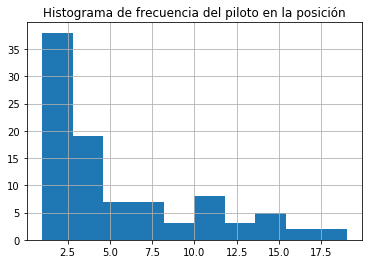

In [8]:
plt.title('Histograma de frecuencia del piloto en la posición')
Monza_GP.groupby(['driverId','carPosition'])['GP'].count().hist()

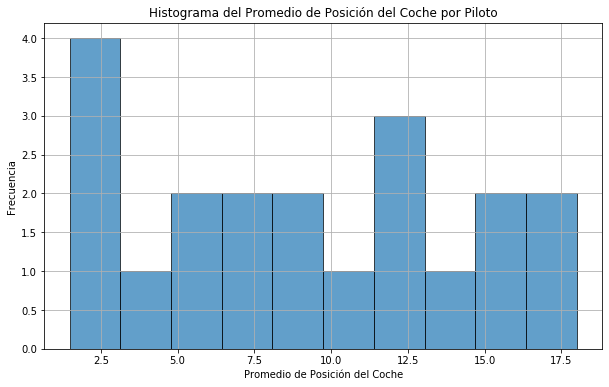

In [9]:
# Calcula el promedio de la posición del coche para cada piloto
promedio_posicion = Monza_GP.groupby('driverId')['carPosition'].mean()

# Crea un histograma del promedio de la posición del coche
plt.figure(figsize=(10, 6))
plt.hist(promedio_posicion, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Promedio de Posición del Coche')
plt.ylabel('Frecuencia')
plt.title('Histograma del Promedio de Posición del Coche por Piloto')
plt.grid(True)
plt.show()

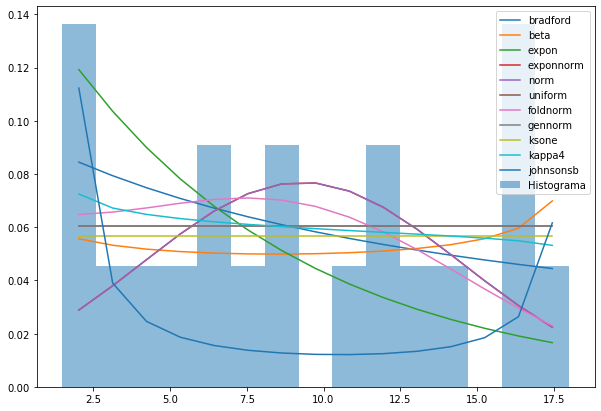

In [10]:
# Lista de distribuciones de probabilidad
dist_list = ['bradford', 'beta', 'expon', 'exponnorm', 'norm', 'uniform', 'foldnorm', 'gennorm', 'ksone', 'kappa4', 'johnsonsb']

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y, x = np.histogram(promedio_posicion, bins=15, density=True)
x = (x + np.roll(x, -1))[:-1] / 2

i = 0
error_df = pd.DataFrame(columns=['distribución', 'error'])

for d in dist_list:
    param = getattr(st, d).fit(promedio_posicion)
    y_hat = getattr(st, d).pdf(x, *param)
    error = np.mean((y - y_hat) ** 2)
    error_df.loc[i, 'distribución'] = d
    error_df.loc[i, 'error'] = error
    i += 1

# Ajusta el ancho de las barras del histograma
width = x[1] - x[0]

# Dibuja el histograma
ax.bar(x, y, width=width, alpha=0.5, label='Histograma')

# Dibuja las líneas de las distribuciones
for d in dist_list:
    param = getattr(st, d).fit(promedio_posicion)
    y_hat = getattr(st, d).pdf(x, *param)
    ax.plot(x, y_hat, label=f'{d}')

plt.legend()
plt.show()

# Error cuadrático medio para cada distribución
print(error_df)

La que tiene menor error es kappa4

In [11]:
#Parámetros de distibución kappa4 en nuestros datos
params_Monza = st.kappa4.fit(promedio_posicion)
params_Monza

   distribución     error
0      bradford  0.001499
1          beta  0.001583
2         expon     0.002
3     exponnorm  0.002266
4          norm  0.002266
5       uniform  0.001558
6      foldnorm   0.00182
7       gennorm  0.001558
8         ksone  0.001573
9        kappa4  0.001473
10    johnsonsb  0.002437


(1.0719131313624262,
 0.9749087985405804,
 0.3220321817925935,
 17.267485807942418)

In [12]:
# Prueba de hipótesis
st.kstest(promedio_posicion, lambda promedio_posicion: st.kappa4.cdf(promedio_posicion,*params_Monza))

KstestResult(statistic=0.09619192085524242, pvalue=0.9925838083545099)

Observando nuestro "p-value", vemos que al ser considereablemente alta, podemos aceptar la hipótesis nula, de manera que podemos decir que estadísticamente el promedio de la posición del coche le ayuda a ganar el primer lugar de la carrera. 

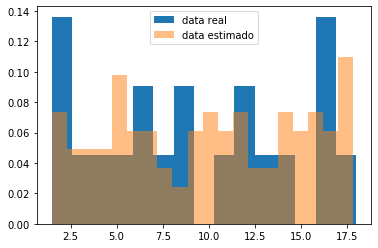

In [13]:
dist='kappa4'
params1 = getattr(st, dist).fit(promedio_posicion)

random_hat1 = getattr(st, dist).rvs(*params1, size = 100)

plt.hist(promedio_posicion, bins =15, label = 'data real', density = True)
plt.hist(random_hat1, bins = 20, density = True, alpha = .5, label = 'data estimado')
plt.legend()
plt.show()

Prueba cuantil-cuantil

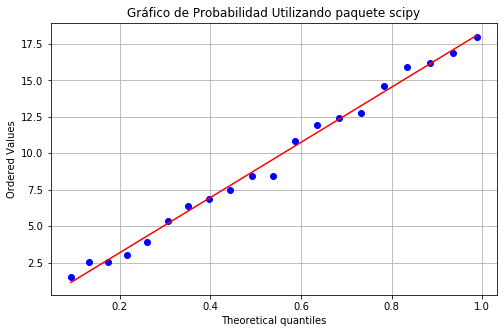

In [14]:
divisiones = 20
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

grap2 = st.probplot(promedio_posicion, dist='kappa4', sparams=getattr(st, 'kappa4').fit(promedio_posicion)[:-2], plot=ax, fit=True)
ax.grid()
ax.set_title('Gráfico de Probabilidad Utilizando paquete scipy')

plt.show()

## Monaco

In [15]:
# Lista de distribuciones de probabilidad
dist_list = ['bradford', 'beta', 'expon', 'exponnorm', 'norm', 'uniform', 'foldnorm', 'gennorm', 'ksone', 'kappa4', 'johnsonsb']

# Crear un diccionario para almacenar los resultados de ajuste de cada distribución
resultados = {}

# Iterar a través de las distribuciones y ajustar a los datos de LapTime para cada piloto
for dist_name in dist_list:
    # Crear un DataFrame para almacenar los parámetros de ajuste para cada piloto
    params_df = pd.DataFrame(columns=['Piloto', 'Parametros'])
    
    for piloto in Monaco_GP['driverId'].unique():
        datos_piloto = Monaco_GP[Monaco_GP['driverId'] == piloto]['carPosition']
        params = getattr(st, dist_name).fit(datos_piloto)
        params_df = params_df.append({'Piloto': piloto, 'Parametros': params}, ignore_index=True)
    
    resultados[dist_name] = params_df

# Obtener la media de cada distribución para cada piloto
medias = {}
for dist_name, params_df in resultados.items():
    params_df['Media'] = params_df['Parametros'].apply(lambda x: np.mean(x))
    piloto_ganador = params_df[params_df['Media'] == params_df['Media'].min()]['Piloto'].values[0]
    medias[dist_name] = (piloto_ganador, params_df['Media'].min())

# Determinar la distribución con la media más baja (es decir, el piloto más probable a ganar)
mejor_dist = min(medias, key=lambda x: medias[x][1])

print(f"La distribución {mejor_dist} tiene al piloto {medias[mejor_dist][0]} como el más probable a ganar.")

La distribución johnsonsb tiene al piloto Lando Norris como el más probable a ganar.


In [16]:
Monaco = Monaco_GP.groupby('driverId')['carPosition'].mean()

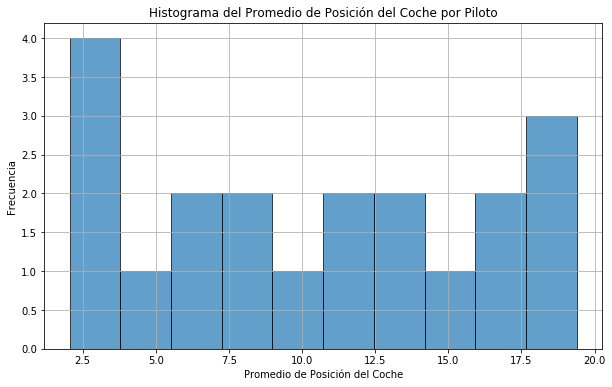

In [17]:
# Calcula el promedio de la posición del coche para cada piloto
promedio_posicion2 = Monaco_GP.groupby('driverId')['carPosition'].mean()

# Crea un histograma del promedio de la posición del coche
plt.figure(figsize=(10, 6))
plt.hist(promedio_posicion2, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Promedio de Posición del Coche')
plt.ylabel('Frecuencia')
plt.title('Histograma del Promedio de Posición del Coche por Piloto')
plt.grid(True)
plt.show()

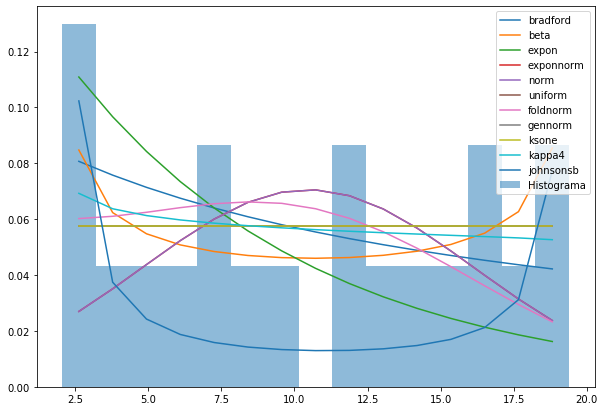

   distribución     error
0      bradford  0.000922
1          beta  0.000617
2         expon  0.001416
3     exponnorm  0.001653
4          norm  0.001653
5       uniform  0.000914
6      foldnorm  0.001272
7       gennorm  0.000914
8         ksone  0.000914
9        kappa4  0.000845
10    johnsonsb  0.001393


In [18]:
# Lista de distribuciones de probabilidad
dist_list = ['bradford', 'beta', 'expon', 'exponnorm', 'norm', 'uniform', 'foldnorm', 'gennorm', 'ksone', 'kappa4', 'johnsonsb']

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y, x = np.histogram(promedio_posicion2, bins=15, density=True)
x = (x + np.roll(x, -1))[:-1] / 2

i = 0
error_df = pd.DataFrame(columns=['distribución', 'error'])

for d in dist_list:
    param = getattr(st, d).fit(promedio_posicion2)
    y_hat = getattr(st, d).pdf(x, *param)
    error = np.mean((y - y_hat) ** 2)
    error_df.loc[i, 'distribución'] = d
    error_df.loc[i, 'error'] = error
    i += 1

# Ajusta el ancho de las barras del histograma
width = x[1] - x[0]

# Dibuja el histograma
ax.bar(x, y, width=width, alpha=0.5, label='Histograma')

# Dibuja las líneas de las distribuciones
for d in dist_list:
    param = getattr(st, d).fit(promedio_posicion2)
    y_hat = getattr(st, d).pdf(x, *param)
    ax.plot(x, y_hat, label=f'{d}')

plt.legend()
plt.show()

# Error cuadrático medio para cada distribución
print(error_df)

In [19]:
#Parámetros de distibución beta en nuestros datos
params_Monaco = st.beta.fit(promedio_posicion2)
params_Monaco

(0.7009690729844666,
 0.6984663446853221,
 2.0499953435243805,
 17.344741498580888)

In [20]:
# Prueba de hipótesis
st.kstest(promedio_posicion2, lambda promedio_posicion2: st.beta.cdf(promedio_posicion2,*params_Monaco))

KstestResult(statistic=0.07063531842459492, pvalue=0.9999660983359386)

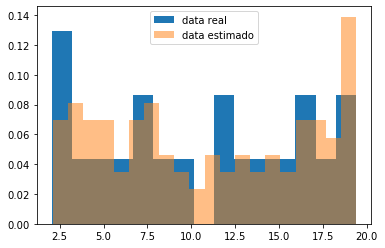

In [21]:
dist='beta'

params2 = getattr(st, dist).fit(promedio_posicion2)

random_hat2 = getattr(st, dist).rvs(*params2, size = 100)

plt.hist(promedio_posicion2, bins =15, label = 'data real', density = True)
plt.hist(random_hat2, bins = 20, density = True, alpha = .5, label = 'data estimado')
plt.legend()
plt.show()

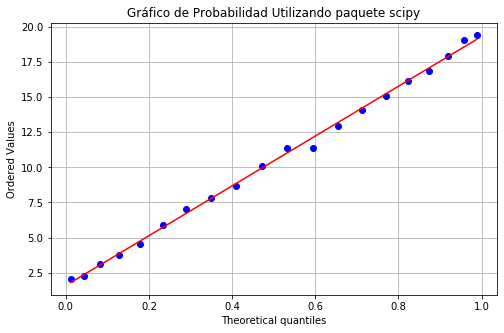

In [22]:
divisiones = 20
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

grap2 = st.probplot(promedio_posicion2, dist='beta', sparams=getattr(st, 'beta').fit(promedio_posicion2)[:-2], plot=ax, fit=True)
ax.grid()
ax.set_title('Gráfico de Probabilidad Utilizando paquete scipy')

plt.show()

# Simulación

## Monza

In [23]:
# Ajusta la distribución kappa4 a los datos de Monza
dist_name = 'kappa4'
param = st.kappa4.fit(promedio_posicion2)

# Simula 10000 escenarios de tiempo de vuelta con la distribución kappa4
num_simulaciones = 10000
tiempos_simulados = st.kappa4.rvs(*param, size=num_simulaciones)

# Crea un DataFrame para almacenar los resultados
resultados_simulacion = pd.DataFrame(columns=['Piloto', 'Tiempo'])

for i in range(num_simulaciones):
    # Obtiene el tiempo simulado
    tiempo_simulado = tiempos_simulados[i]
    
    # Encuentra al piloto ganador en el escenario simulado
    piloto_ganador = Monza_GP[Monza_GP['carPosition'] == Monza_GP['carPosition'].min()]['driverId'].values[0]
    
    # Agrega los resultados a DataFrame
    resultados_simulacion = resultados_simulacion.append({'Piloto': piloto_ganador, 'Tiempo': tiempo_simulado}, ignore_index=True)

# Ordena los pilotos ganadores por tiempo simulado
resultados_simulacion = resultados_simulacion.sort_values(by='Tiempo')

# Obtiene el piloto más probable a ganar en el primer escenario simulado
piloto_mas_probable_a_ganar = resultados_simulacion.iloc[0]['Piloto']

print(f"El piloto más probable a ganar en Monza en los 10,000 escenarios simulados es el piloto con driverId: {piloto_mas_probable_a_ganar}")

El piloto más probable a ganar en Monza en los 10,000 escenarios simulados es el piloto con driverId: Lewis Hamilton


In [24]:
# Ajusta la distribución kappa4 a los datos de Monza
dist_name = 'kappa4'
param = st.kappa4.fit(promedio_posicion)

# Simula 1000 escenarios de tiempo de vuelta con la distribución Johnson SB
num_simulaciones = 10000
tiempos_simulados = st.kappa4.rvs(*param, size=num_simulaciones)

# Determina el piloto ganador en cada escenario simulado
piloto_ganador_simulaciones = []

for _ in range(num_simulaciones):
    tiempo_simulado = st.kappa4.rvs(*param)
    piloto_ganador_simulaciones.append((tiempo_simulado, Monza_GP[Monza_GP['carPosition'] == min(Monza_GP['carPosition'])]['driverId'].values[0]))

# Ordena los pilotos ganadores por tiempo simulado
piloto_ganador_simulaciones.sort(key=lambda x: x[0])

# El piloto más probable a ganar en Monza en el primer escenario simulado
piloto_mas_probable_a_ganar = piloto_ganador_simulaciones[0][1]

print(f"El piloto más probable a ganar en Monza es: {piloto_mas_probable_a_ganar}")

El piloto más probable a ganar en Monza es: Lewis Hamilton


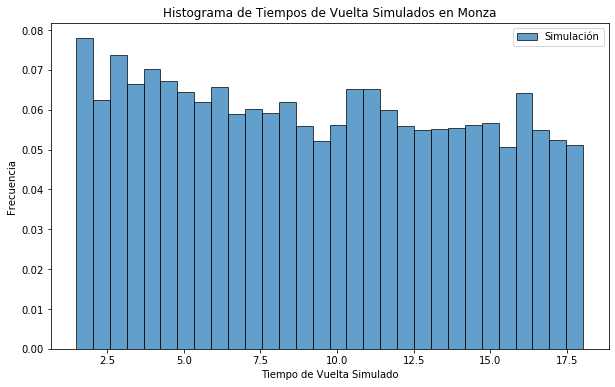

In [25]:
# Crea un histograma de los tiempos simulados
plt.figure(figsize=(10, 6))
plt.hist(tiempos_simulados, bins=30, edgecolor='black', alpha=0.7, density=True, label='Simulación')
plt.xlabel('Tiempo de Vuelta Simulado')
plt.ylabel('Frecuencia')
plt.title('Histograma de Tiempos de Vuelta Simulados en Monza')
plt.legend()
plt.show()

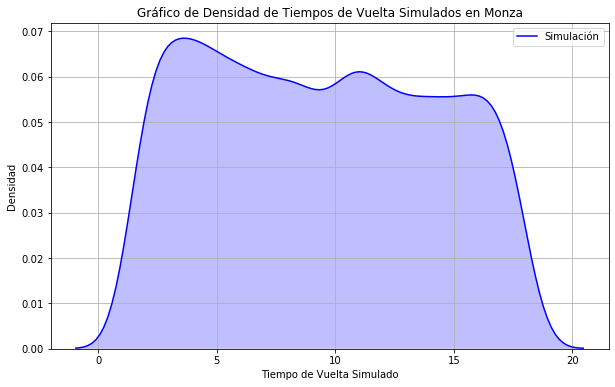

In [26]:
# Crea un gráfico de densidad KDE para los tiempos de vuelta simulados
plt.figure(figsize=(10, 6))
sns.kdeplot(tiempos_simulados, shade=True, label='Simulación', color='blue')
plt.xlabel('Tiempo de Vuelta Simulado')
plt.ylabel('Densidad')
plt.title('Gráfico de Densidad de Tiempos de Vuelta Simulados en Monza')
plt.legend()
plt.grid(True)
plt.show()

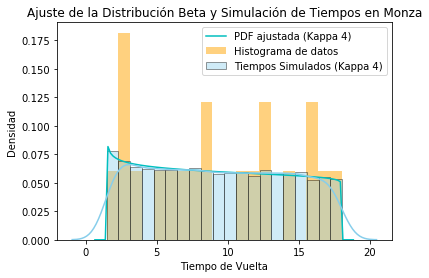

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st

# Ajuste de la distribución Kappa 4 a los datos
param_kappa4 = st.kappa4.fit(promedio_posicion)

# Histograma de los datos
plt.hist(promedio_posicion, bins=20, density=True, alpha=0.5, color='orange', label='Histograma de datos')

# Función de densidad ajustada (PDF Kappa 4)
xmin, xmax = plt.xlim()
x_kappa4 = np.linspace(xmin, xmax, 100)
pdf_fitted_kappa4 = st.kappa4.pdf(x_kappa4, *param_kappa4)
plt.plot(x_kappa4, pdf_fitted_kappa4, 'c-', label='PDF ajustada (Kappa 4)')

# Simulación de escenarios de tiempo de vuelta con la distribución Kappa 4
num_simulaciones = 10000
tiempos_simulados_kappa4 = st.kappa4.rvs(*param_kappa4, size=num_simulaciones)

# Histograma de los tiempos simulados
sns.distplot(tiempos_simulados_kappa4, bins=20, kde=True, color='skyblue', hist_kws={'edgecolor': 'black'}, label='Tiempos Simulados (Kappa 4)')

# Etiquetas y título
plt.title('Ajuste de la Distribución Kappa4 y Simulación de Tiempos en Monza')
plt.xlabel('Tiempo de Vuelta')
plt.ylabel('Densidad')
plt.legend()
plt.show()

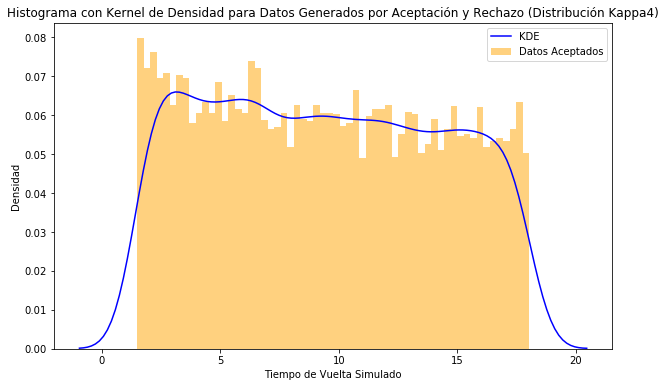

In [64]:
# Ajusta la distribución kappa4 a los datos de Monza
dist_name = 'kappa4'
param = st.kappa4.fit(promedio_posicion)

# Simula 10000 escenarios de tiempo de vuelta con la distribución kappa4
num_simulaciones = 10000
tiempos_simulados = st.kappa4.rvs(*param, size=num_simulaciones)

# Genera datos para el método de aceptación y rechazo
aceptados = []
rechazados = []

# Usa el método de aceptación y rechazo para generar datos
for i in range(num_simulaciones):
    propuesta = st.kappa4.rvs(*param)
    f_propuesta = st.kappa4.pdf(propuesta, *param)
    u = np.random.uniform(0, st.kappa4.pdf(propuesta, *param))

    if u <= f_propuesta:
        aceptados.append(propuesta)
    else:
        rechazados.append(propuesta)

# Crea un histograma con kernel de densidad para los datos generados
plt.figure(figsize=(10, 6))

# Histograma
plt.hist(aceptados, bins=60, density=True, alpha=0.5, color='orange', label='Datos Aceptados')

# KDE
sns.kdeplot(aceptados, color='blue', label='KDE')

# Añade etiquetas y título al gráfico
plt.title('Histograma con Kernel de Densidad para Datos Generados por Aceptación y Rechazo (Distribución Kappa4)')
plt.xlabel('Tiempo de Vuelta Simulado')
plt.ylabel('Densidad')
plt.legend()

# Muestra el gráfico
plt.show()

## Monaco

In [27]:
# Ajusta la distribución beta a los datos de Monaco
dist_name = 'beta'
param = st.beta.fit(promedio_posicion2)

# Simula 1000 escenarios de tiempo de vuelta con la distribución Johnson SB
num_simulaciones = 10000
tiempos_simulados = st.beta.rvs(*param, size=num_simulaciones)

# Determina el piloto ganador en cada escenario simulado
piloto_ganador_simulaciones = []

for _ in range(num_simulaciones):
    tiempo_simulado = st.beta.rvs(*param)
    piloto_ganador_simulaciones.append((tiempo_simulado, Monaco_GP[Monaco_GP['carPosition'] == min(Monaco_GP['carPosition'])]['driverId'].values[0]))

# Ordena los pilotos ganadores por tiempo simulado
piloto_ganador_simulaciones.sort(key=lambda x: x[0])

# El piloto más probable a ganar en Monza en el primer escenario simulado
piloto_mas_probable_a_ganar = piloto_ganador_simulaciones[0][1]

print(f"El piloto más probable a ganar en Monaco es: {piloto_mas_probable_a_ganar}")

El piloto más probable a ganar en Monaco es: Max Verstappen


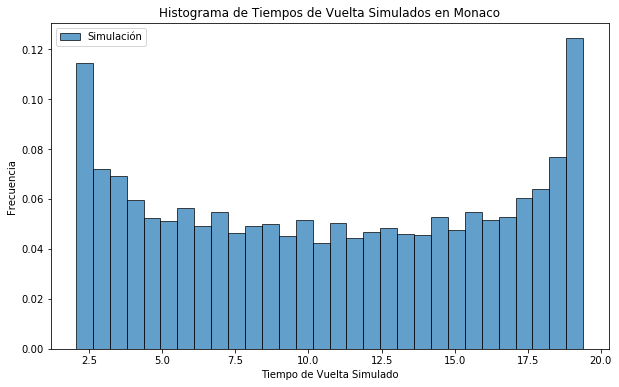

In [28]:
# Crea un histograma de los tiempos simulados
plt.figure(figsize=(10, 6))
plt.hist(tiempos_simulados, bins=30, edgecolor='black', alpha=0.7, density=True, label='Simulación')
plt.xlabel('Tiempo de Vuelta Simulado')
plt.ylabel('Frecuencia')
plt.title('Histograma de Tiempos de Vuelta Simulados en Monaco')
plt.legend()
plt.show()

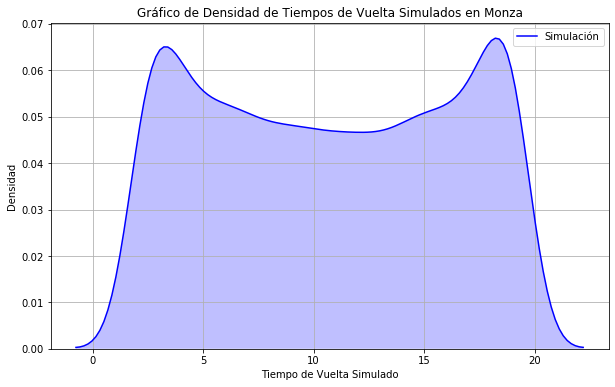

In [29]:
# Crea un gráfico de densidad KDE para los tiempos de vuelta simulados
plt.figure(figsize=(10, 6))
sns.kdeplot(tiempos_simulados, shade=True, label='Simulación', color='blue')
plt.xlabel('Tiempo de Vuelta Simulado')
plt.ylabel('Densidad')
plt.title('Gráfico de Densidad de Tiempos de Vuelta Simulados en Monza')
plt.legend()
plt.grid(True)
plt.show()


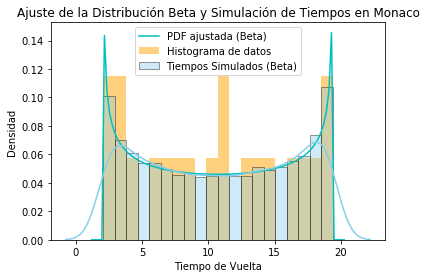

In [48]:
# Ajuste de la distribución beta a los datos de Monaco
param_beta = st.beta.fit(promedio_posicion2)

# Histograma de los datos
plt.hist(promedio_posicion2, bins=20, density=True, alpha=0.5, color='orange', label='Histograma de datos')

# Función de densidad ajustada (PDF beta)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf_fitted_beta = st.beta.pdf(x, *param_beta)
plt.plot(x, pdf_fitted_beta, 'c-', label='PDF ajustada (Beta)')

# Simulación de escenarios de tiempo de vuelta con la distribución beta
num_simulaciones = 10000
tiempos_simulados_beta = st.beta.rvs(*param_beta, size=num_simulaciones)

# Histograma de los tiempos simulados
sns.distplot(tiempos_simulados_beta, bins=20, kde=True, color='skyblue', hist_kws={'edgecolor': 'black'}, label='Tiempos Simulados (Beta)')

# Etiquetas y título
plt.title('Ajuste de la Distribución Beta y Simulación de Tiempos en Monaco')
plt.xlabel('Tiempo de Vuelta')
plt.ylabel('Densidad')
plt.legend()
plt.show()

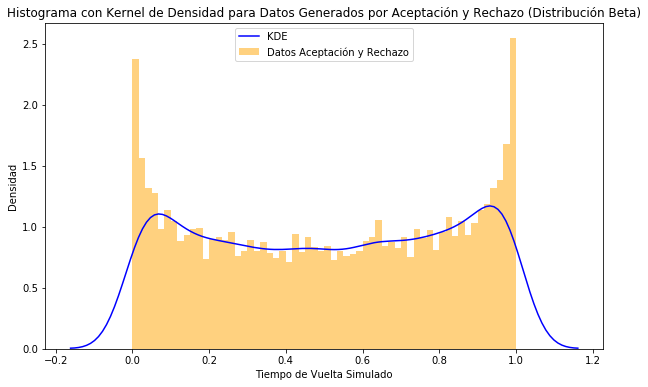

In [62]:
# Ajusta la distribución beta a los datos de Monaco
dist_name = 'beta'
param = st.beta.fit(promedio_posicion2)

# Simula 10000 escenarios de tiempo de vuelta con la distribución beta
num_simulaciones = 10000
tiempos_simulados = st.beta.rvs(*param, size=num_simulaciones)

# Genera datos para el método de aceptación y rechazo
aceptados = []
rechazados = []

# Usa el método de aceptación y rechazo para generar datos
for i in range(num_simulaciones):
    propuesta = np.random.beta(param[0], param[1])
    f_propuesta = st.beta.pdf(propuesta, *param)
    u = np.random.uniform(0, st.beta.pdf(propuesta, *param))

    if u <= f_propuesta:
        aceptados.append(propuesta)
    else:
        rechazados.append(propuesta)

# Crea un histograma con kernel de densidad para los datos generados
plt.figure(figsize=(10, 6))

# Histograma
plt.hist(aceptados, bins=60, density=True, alpha=0.5, color='orange', label='Datos Aceptación y Rechazo')

# KDE
sns.kdeplot(aceptados, color='blue', label='KDE')

# Añade etiquetas y título al gráfico
plt.title('Histograma con Kernel de Densidad para Datos Generados por Aceptación y Rechazo (Distribución Beta)')
plt.xlabel('Tiempo de Vuelta Simulado')
plt.ylabel('Densidad')
plt.legend()

# Muestra el gráfico
plt.show()

# Más probables a abandonar

## Monza

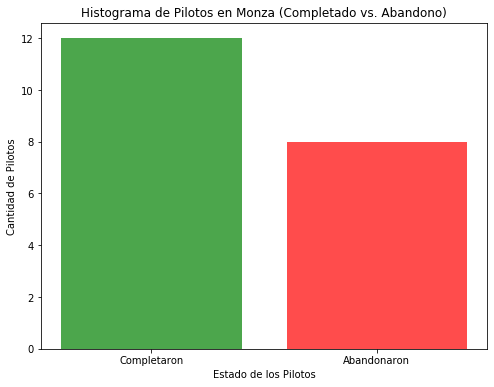

   Distribución         Error
0      bradford  2.208600e+06
1          beta  1.282744e+27
2         expon           NaN
3     exponnorm  2.756118e+46
4          norm           NaN
5       uniform           NaN
6      foldnorm  6.823741e+43
7       gennorm  1.606976e+43
8         ksone  1.384152e+38
9        kappa4  1.160618e+27
10    johnsonsb  1.500000e+01


In [30]:
def histo(Monza_GP):
    # Define el número total de vueltas requeridas
    vueltas_totales = 27

    # Encuentra el último registro de cada piloto
    ultimo_registro = Monza_GP.groupby('driverId')['currentLapNum'].max().reset_index()

    # Filtra los pilotos que completaron exactamente las 27 vueltas y los que abandonaron
    completaron = ultimo_registro[ultimo_registro['currentLapNum'] == vueltas_totales]
    abandonaron = ultimo_registro[ultimo_registro['currentLapNum'] != vueltas_totales]

    # Crea el histograma
    plt.figure(figsize=(8, 6))
    plt.bar(['Completaron', 'Abandonaron'], [len(completaron), len(abandonaron)], color=['green', 'red'], alpha=0.7)
    plt.xlabel("Estado de los Pilotos")
    plt.ylabel("Cantidad de Pilotos")
    plt.title("Histograma de Pilotos en Monza (Completado vs. Abandono)")
    plt.show()

    # Datos para calcular errores
    y, x = np.histogram(completaron['currentLapNum'], bins=15, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2

    # Inicializa un DataFrame para los errores
    error_df = pd.DataFrame(columns=['Distribución', 'Error'])

    # Lista de distribuciones de probabilidad
    dist_list = ['bradford', 'beta', 'expon', 'exponnorm', 'norm', 'uniform', 'foldnorm', 'gennorm', 'ksone', 'kappa4', 'johnsonsb']

    # Ajusta y calcula errores para cada distribución
    for dist_name in dist_list:
        dist = getattr(st, dist_name)
        params = dist.fit(completaron['currentLapNum'])
        y_hat = dist.pdf(x, *params)
        error = np.mean((y - y_hat) ** 2)
        error_df = error_df.append({'Distribución': dist_name, 'Error': error}, ignore_index=True)

    # Muestra la tabla de errores
    print(error_df)

# Llama a la función con tus datos
histo(Monza_GP)

In [31]:
def remove_outliers2(sim_data,columna):
    Q1 = sim_data[columna].quantile(0.25)
    Q3 = sim_data[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    s_data = sim_data[(sim_data[columna] >= lower_limit) & (sim_data[columna] <= upper_limit)]
    
    return s_data,lower_limit,upper_limit

In [32]:
def rectangular_KDE(dataframe,columna,label):
    datos, ll, ul = remove_outliers2(dataframe,columna)
    b = datos[columna].values
    kde = st.gaussian_kde(b, bw_method='silverman')  # bw_method es el ancho de banda

    # Generar puntos de la gráfica para el KDE
    x = np.linspace(np.min(b), np.max(b), 1000)
    y = kde.evaluate(x)

    # Gráfico del KDE con kernel rectangular
    plt.plot(x, y, label=label, color='blue')
    plt.fill_between(x, 0, y, alpha=0.5, color='blue')  # Relleno bajo la curva

    # Mostrar el gráfico
    plt.title('KDE con Kernel Rectangular')
    plt.xlabel('Tiempo (s)')
    plt.legend()
    plt.show()

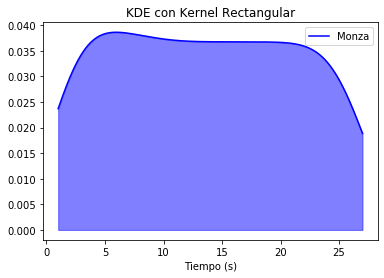

In [33]:
rectangular_KDE(Monza_GP,'currentLapNum','Monza')

## Monaco

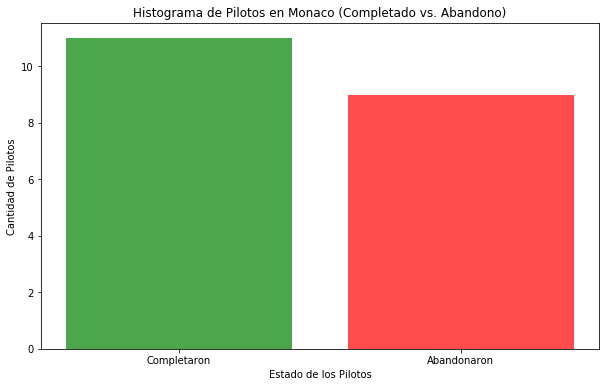

In [34]:
# Define el número total de vueltas requeridas
vueltas_totales = 39

# Encuentra el último registro de cada piloto
ultimo_registro = Monaco_GP.groupby('driverId')['currentLapNum'].max().reset_index()

# Filtra los pilotos que completaron exactamente las 39 vueltas y los que abandonaron
completaron = ultimo_registro[ultimo_registro['currentLapNum'] == vueltas_totales]
abandonaron = ultimo_registro[ultimo_registro['currentLapNum'] != vueltas_totales]

# Crea el histograma
plt.figure(figsize=(10, 6))
plt.bar(['Completaron', 'Abandonaron'], [len(completaron), len(abandonaron)], color=['green', 'red'], alpha=0.7)
plt.xlabel("Estado de los Pilotos")
plt.ylabel("Cantidad de Pilotos")
plt.title("Histograma de Pilotos en Monaco (Completado vs. Abandono)")
plt.show()

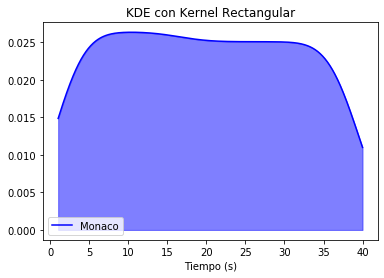

In [35]:
rectangular_KDE(Monaco_GP,'currentLapNum','Monaco')

## Simulación

In [36]:
# Define el número total de vueltas requeridas
vueltas_totales = 39

# Obtén los pilotos únicos en el DataFrame
pilotos_unicos = Monaco_GP['driverId'].unique()

# Inicializa un diccionario para realizar un seguimiento de los pilotos que abandonaron
abandonos_por_piloto = {piloto: 0 for piloto in pilotos_unicos}

# Número de simulaciones
num_simulaciones = 10000

# Realiza la simulación
for _ in range(num_simulaciones):
    for piloto in pilotos_unicos:
        # Verifica si el piloto abandona o completa la carrera
        abandona = False
        if piloto in abandonos_por_piloto:
            abandonos_previos = abandonos_por_piloto[piloto]
            if abandonos_previos < vueltas_totales:
                abandona = True
                abandonos_por_piloto[piloto] += 1
        else:
            abandonos_por_piloto[piloto] = 1 if piloto not in abandonos_por_piloto else 0
        
# Encuentra el piloto que más veces abandonó
piloto_mas_probable_abandonar = max(abandonos_por_piloto, key=abandonos_por_piloto.get)

# Imprimir el piloto más probable de abandonar
print("Piloto más probable de abandonar:", piloto_mas_probable_abandonar)

Piloto más probable de abandonar: Carlos Sainz


## Generación de PDF

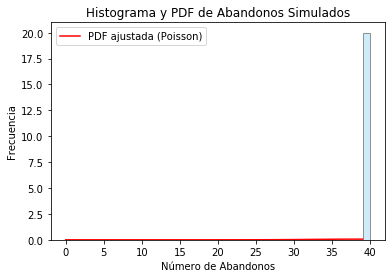

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Número total de vueltas requeridas
vueltas_totales = 39

# Obtén los pilotos únicos en el DataFrame
pilotos_unicos = Monaco_GP['driverId'].unique()

# Inicializa un diccionario para realizar un seguimiento de los pilotos que abandonaron
abandonos_por_piloto = {piloto: 0 for piloto in pilotos_unicos}

# Número de simulaciones
num_simulaciones = 10000

# Realiza la simulación
for _ in range(num_simulaciones):
    for piloto in pilotos_unicos:
        # Verifica si el piloto abandona o completa la carrera
        abandona = False
        if piloto in abandonos_por_piloto:
            abandonos_previos = abandonos_por_piloto[piloto]
            if abandonos_previos < vueltas_totales:
                abandona = True
                abandonos_por_piloto[piloto] += 1
        else:
            abandonos_por_piloto[piloto] = 1 if piloto not in abandonos_por_piloto else 0

# Obtén la cantidad de abandonos por piloto
abandonos_pilotos = list(abandonos_por_piloto.values())

# Ajustar una distribución de Poisson a los datos
mu, std = np.mean(abandonos_pilotos), np.std(abandonos_pilotos)
distribucion_poisson = poisson(mu)

# Generar datos para la PDF ajustada
x = np.arange(0, vueltas_totales + 1)
pdf_ajustada = distribucion_poisson.pmf(x)

# Crear un histograma con KDE
sns.distplot(abandonos_pilotos, bins=range(vueltas_totales + 2), kde=False, color='skyblue', hist_kws={'edgecolor':'black'})

# Graficar la PDF ajustada
plt.plot(x, pdf_ajustada, 'r-', label='PDF ajustada (Poisson)')

# Personalizar el gráfico
plt.title('Histograma y PDF de Abandonos Simulados')
plt.xlabel('Número de Abandonos')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

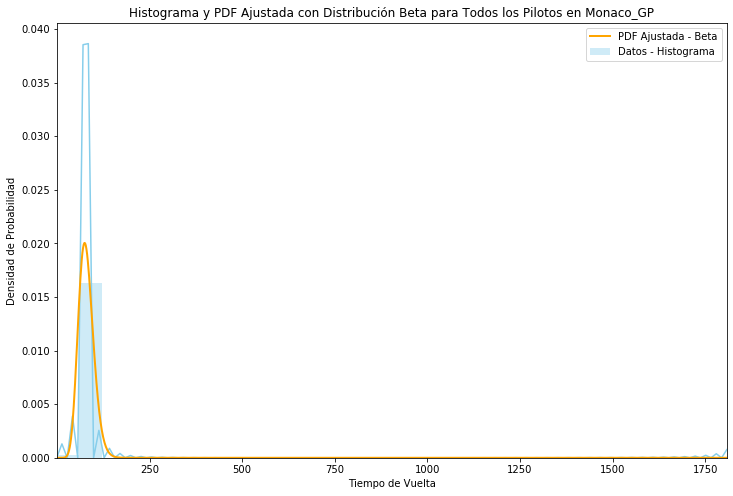

Parámetros para la distribución Beta: (21.187555108836897, 100789811540630.39, -14.312393839916545, 444537587794441.2)


In [75]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns

# Obtén todos los tiempos de vuelta de Monaco_GP
tiempos_vuelta_monacogp = Monaco_GP['LapTime']

# Ajusta la distribución Beta
parametros_beta = st.beta.fit(tiempos_vuelta_monacogp)

# Crear gráfica de histograma y PDF ajustada
plt.figure(figsize=(12, 8))

# Histograma
sns.distplot(tiempos_vuelta_monacogp, bins=30, kde=True, color='skyblue', label='Datos - Histograma')

# PDF ajustada
x = np.linspace(min(tiempos_vuelta_monacogp), max(tiempos_vuelta_monacogp), 1000)
pdf_ajustada = st.beta.pdf(x, *parametros_beta)
plt.plot(x, pdf_ajustada, label='PDF Ajustada - Beta', color='orange', linewidth=2)

plt.xlabel('Tiempo de Vuelta')
plt.ylabel('Densidad de Probabilidad')
plt.title('Histograma y PDF Ajustada con Distribución Beta para Todos los Pilotos en Monaco_GP')
plt.legend()

# Ajustar límites del eje x para hacer zoom
plt.xlim(min(tiempos_vuelta_monacogp), max(tiempos_vuelta_monacogp))

plt.show()

# Imprimir parámetros de la distribución ajustada
print(f'Parámetros para la distribución Beta: {parametros_beta}')


In [40]:
# Define el número total de vueltas requeridas
vueltas_totales = 27

# Obtén los pilotos únicos en el DataFrame
pilotos_unicos = Monza_GP['driverId'].unique()

# Inicializa un diccionario para realizar un seguimiento de los pilotos que abandonaron
abandonos_por_piloto = {piloto: 0 for piloto in pilotos_unicos}

# Número de simulaciones
num_simulaciones = 10000

# Realiza la simulación
for _ in range(num_simulaciones):
    for piloto in pilotos_unicos:
        # Verifica si el piloto abandona o completa la carrera
        abandona = False
        if piloto in abandonos_por_piloto:
            abandonos_previos = abandonos_por_piloto[piloto]
            if abandonos_previos < vueltas_totales:
                abandona = True
                abandonos_por_piloto[piloto] += 1
        else:
            abandonos_por_piloto[piloto] = 1 if piloto not in abandonos_por_piloto else 0
        
# Encuentra el piloto que más veces abandonó
piloto_mas_probable_abandonar = max(abandonos_por_piloto, key=abandonos_por_piloto.get)

# Imprimir el piloto más probable de abandonar
print("Piloto más probable de abandonar:", piloto_mas_probable_abandonar)

Piloto más probable de abandonar: Lance Stroll


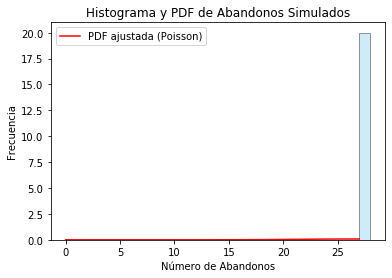

In [53]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Número total de vueltas requeridas
vueltas_totales = 27

# Obtén los pilotos únicos en el DataFrame
pilotos_unicos = Monza_GP['driverId'].unique()

# Inicializa un diccionario para realizar un seguimiento de los pilotos que abandonaron
abandonos_por_piloto = {piloto: 0 for piloto in pilotos_unicos}

# Número de simulaciones
num_simulaciones = 10000

# Realiza la simulación
for _ in range(num_simulaciones):
    for piloto in pilotos_unicos:
        # Verifica si el piloto abandona o completa la carrera
        abandona = False
        if piloto in abandonos_por_piloto:
            abandonos_previos = abandonos_por_piloto[piloto]
            if abandonos_previos < vueltas_totales:
                abandona = True
                abandonos_por_piloto[piloto] += 1
        else:
            abandonos_por_piloto[piloto] = 1 if piloto not in abandonos_por_piloto else 0

# Obtén la cantidad de abandonos por piloto
abandonos_pilotos = list(abandonos_por_piloto.values())

# Ajustar una distribución de Poisson a los datos
mu, std = np.mean(abandonos_pilotos), np.std(abandonos_pilotos)
distribucion_poisson = poisson(mu)

# Generar datos para la PDF ajustada
x = np.arange(0, vueltas_totales + 1)
pdf_ajustada = distribucion_poisson.pmf(x)

# Crear un histograma con KDE
sns.distplot(abandonos_pilotos, bins=range(vueltas_totales + 2), kde=False, color='skyblue', hist_kws={'edgecolor':'black'})

# Graficar la PDF ajustada
plt.plot(x, pdf_ajustada, 'r-', label='PDF ajustada (Poisson)')

# Personalizar el gráfico
plt.title('Histograma y PDF de Abandonos Simulados')
plt.xlabel('Número de Abandonos')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

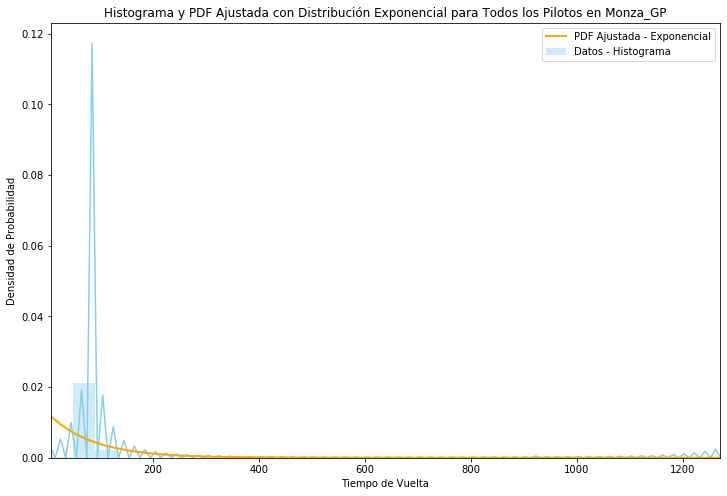

Parámetros para la distribución Exponencial: (6.85152, 84.32285748979592)


In [78]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns

# Obtén todos los tiempos de vuelta de Monza_GP
tiempos_vuelta_monzagp = Monza_GP['LapTime']

# Ajusta la distribución exponencial
parametros_exponencial = st.expon.fit(tiempos_vuelta_monzagp)

# Crear gráfica de histograma y PDF ajustada
plt.figure(figsize=(12, 8))

# Histograma
sns.distplot(tiempos_vuelta_monzagp, bins=30, kde=True, color='skyblue', label='Datos - Histograma')

# PDF ajustada
x = np.linspace(min(tiempos_vuelta_monzagp), max(tiempos_vuelta_monzagp), 1000)
pdf_ajustada = st.expon.pdf(x, *parametros_exponencial)
plt.plot(x, pdf_ajustada, label='PDF Ajustada - Exponencial', color='orange', linewidth=2)

plt.xlabel('Tiempo de Vuelta')
plt.ylabel('Densidad de Probabilidad')
plt.title('Histograma y PDF Ajustada con Distribución Exponencial para Todos los Pilotos en Monza_GP')
plt.legend()

# Ajustar límites del eje x para hacer zoom
plt.xlim(min(tiempos_vuelta_monzagp), max(tiempos_vuelta_monzagp))

plt.show()

# Imprimir parámetros de la distribución ajustada
print(f'Parámetros para la distribución Exponencial: {parametros_exponencial}')

> **Ganador del GP**
   - En Monza y en Mónaco se obtuvo como resultado Hamilton y Max, que era lo que se esperaba ya que tuvieron una muy buena temporada y fueron de los corredores con mejores tiempos.

> **Abandonar**
   - Al momento de abandonar depende mucho de la pista, como se puede ver en este caso en Monza todos terminaron la carrera mientras que en la de Mónaco que se considera una de las pistas más complicadas un poco menos de la mitad tuvieron que abandonar la carrera.
   - Nuestras simulaciones nos muestran que Lance y Sainz son los más probables a abandonar, aunque esto no concuerda con nuestra hipótesis podemos suponer que los datos que se tenían en el dataset de ese año no era lo que esperabamos 

## Simulación